In [1]:
import pandas as pd
from utils.utils import reshample_time_serie

buenaventura_route = r"D:\master BigData\01 proyecto final\datos\IDEAM_ST\prec\buenaventura_ideam.csv"
juanchaco_route = r"D:\master BigData\01 proyecto final\datos\IDEAM_ST\prec\juanchaco.csv"


serie_buenaventura = pd.read_csv(buenaventura_route)
serie_juanchaco = pd.read_csv(juanchaco_route)
# Convierte la columna 'Fecha' a tipo datetime
serie_buenaventura['Fecha'] = pd.to_datetime(serie_buenaventura['Fecha'])
serie_juanchaco['Fecha'] = pd.to_datetime(serie_juanchaco['Fecha'])
# Establece la columna 'Fecha' como el índice
serie_buenaventura.set_index('Fecha', inplace=True)
serie_juanchaco.set_index('Fecha', inplace=True)
# Si el índice ya tiene una zona horaria asociada, usa tz_convert en lugar de tz_localize
serie_buenaventura.index = serie_buenaventura.index.tz_localize('UTC').tz_convert('America/Bogota')
serie_juanchaco.index = serie_juanchaco.index.tz_localize('UTC').tz_convert('America/Bogota')

serie_buenaventura.rename(columns={'Valor': 'value'}, inplace=True)

#serie_tumaco = reshample_time_serie(serie_tumaco, 'D', 'sum')

In [3]:
from api_somo import fetch_and_process_data
import numpy as np

api_filtrate_seire = "http://127.0.0.1:8000/database/filter-serie-qf/"
tumaco_fetch = {"station_name": "juanchaco","variable_name": "Precipitación acumulada","processing_level_name": "Control de calidad"}
serie_cccp = fetch_and_process_data(api_filtrate_seire, tumaco_fetch)
serie_cccp.loc[~serie_cccp['qf'].isin([1, 3]), 'value'] = np.nan




d:\master BigData\01 proyecto final\codigos\bigdata\utils\utils.py:109: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  primera_columna_remuestreada = value.resample(nueva_frecuencia).sum()
d:\master BigData\01 proyecto final\codigos\bigdata\utils\utils.py:120: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  otras_columnas_remuestreadas = serie_original.resample(nueva_frecuencia).first()


In [4]:
dfs = []

# PREPROCESAMIENTO DE LAS SERIES 
# Renombra la columna de valores a algo único por estación
serie_cccp.rename(columns={"value": 'CCCP'}, inplace=True)
# Agrega el DataFrame a la lista (seleccionando solo la columna renombrada)
dfs.append(serie_cccp[['CCCP']])

# Renombra la columna de valores a algo único por estación
serie_buenaventura.rename(columns={"value": 'IDEAM'}, inplace=True)
# Agrega el DataFrame a la lista (seleccionando solo la columna renombrada)
dfs.append(serie_buenaventura[['IDEAM']])

# Combina todas las series temporales usando el índice (timestamp)
data_stations = pd.concat(dfs, axis=1)

# Ordena por el índice (timestamp)
data_stations.sort_index(inplace=True)

# Resultados y estadísticas
print(f"Longitud serie CCCP: {len(serie_cccp)}, y la de IDEAM: {len(serie_buenaventura)}")
print(f'La tabla general es:\n{data_stations}')


Longitud serie CCCP: 80593, y la de IDEAM: 37726
La tabla general es:
                           CCCP  IDEAM
2013-10-22 05:00:00+00:00   NaN    NaN
2013-10-22 06:00:00+00:00   NaN    NaN
2013-10-22 07:00:00+00:00   NaN    NaN
2013-10-22 08:00:00+00:00   NaN    NaN
2013-10-22 09:00:00+00:00   NaN    NaN
...                         ...    ...
2023-01-01 01:00:00+00:00   0.0    NaN
2023-01-01 02:00:00+00:00   0.0    NaN
2023-01-01 03:00:00+00:00   0.0    NaN
2023-01-01 04:00:00+00:00   0.0    NaN
2023-01-01 05:00:00+00:00   0.0    NaN

[80593 rows x 2 columns]


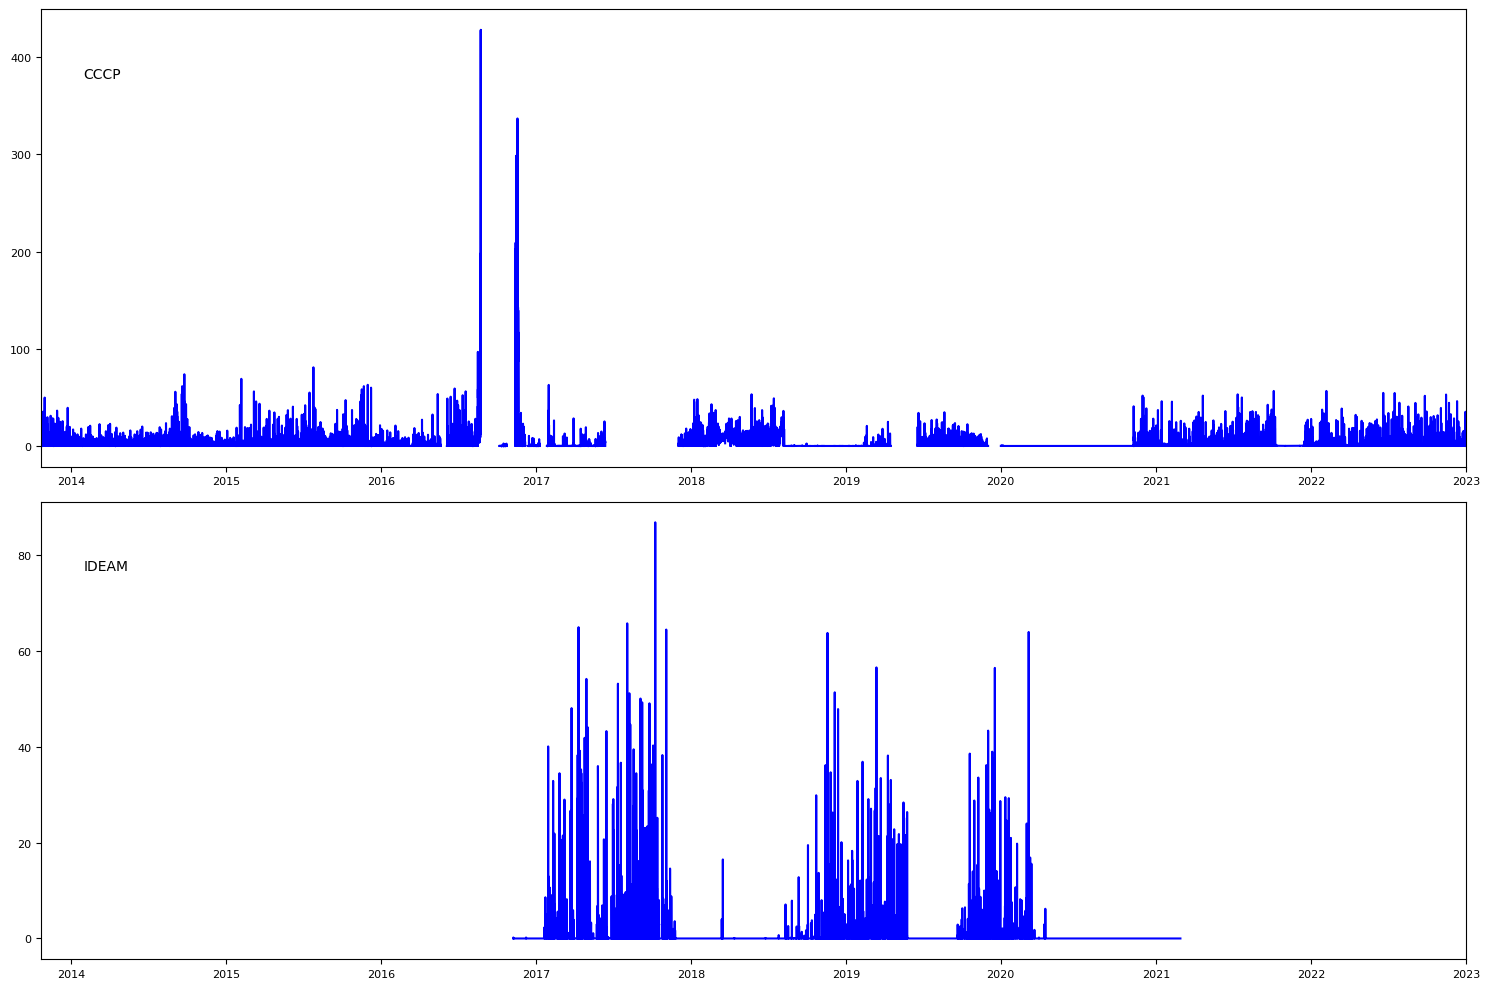

In [5]:
# Gráficar
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=data_stations.shape[1], ncols=1, figsize=(15, 10)) # Ajustar el número de "nrows" por el número de columnas a gráficar
for i, col in enumerate(data_stations.columns[0:]):
    fila = i
    columna = 0
    ax = axs[fila]
    ax.plot(data_stations.index, data_stations[col], color='blue')
    ax.set_ylabel('', fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.set_xlim(data_stations.index.min(), data_stations.index.max())
    ax.text(0.03, 0.85, col, transform=ax.transAxes, fontsize=10)
plt.subplots_adjust(hspace=0.05)
plt.tight_layout()
plt.show()

In [6]:
#Muestra cuantas celdas con datos nulos o faltantes tiene cada columna de la base de datos
data_stations.isnull().sum()


CCCP     10480
IDEAM    42867
dtype: int64

CCCP     0
IDEAM    0
dtype: int64


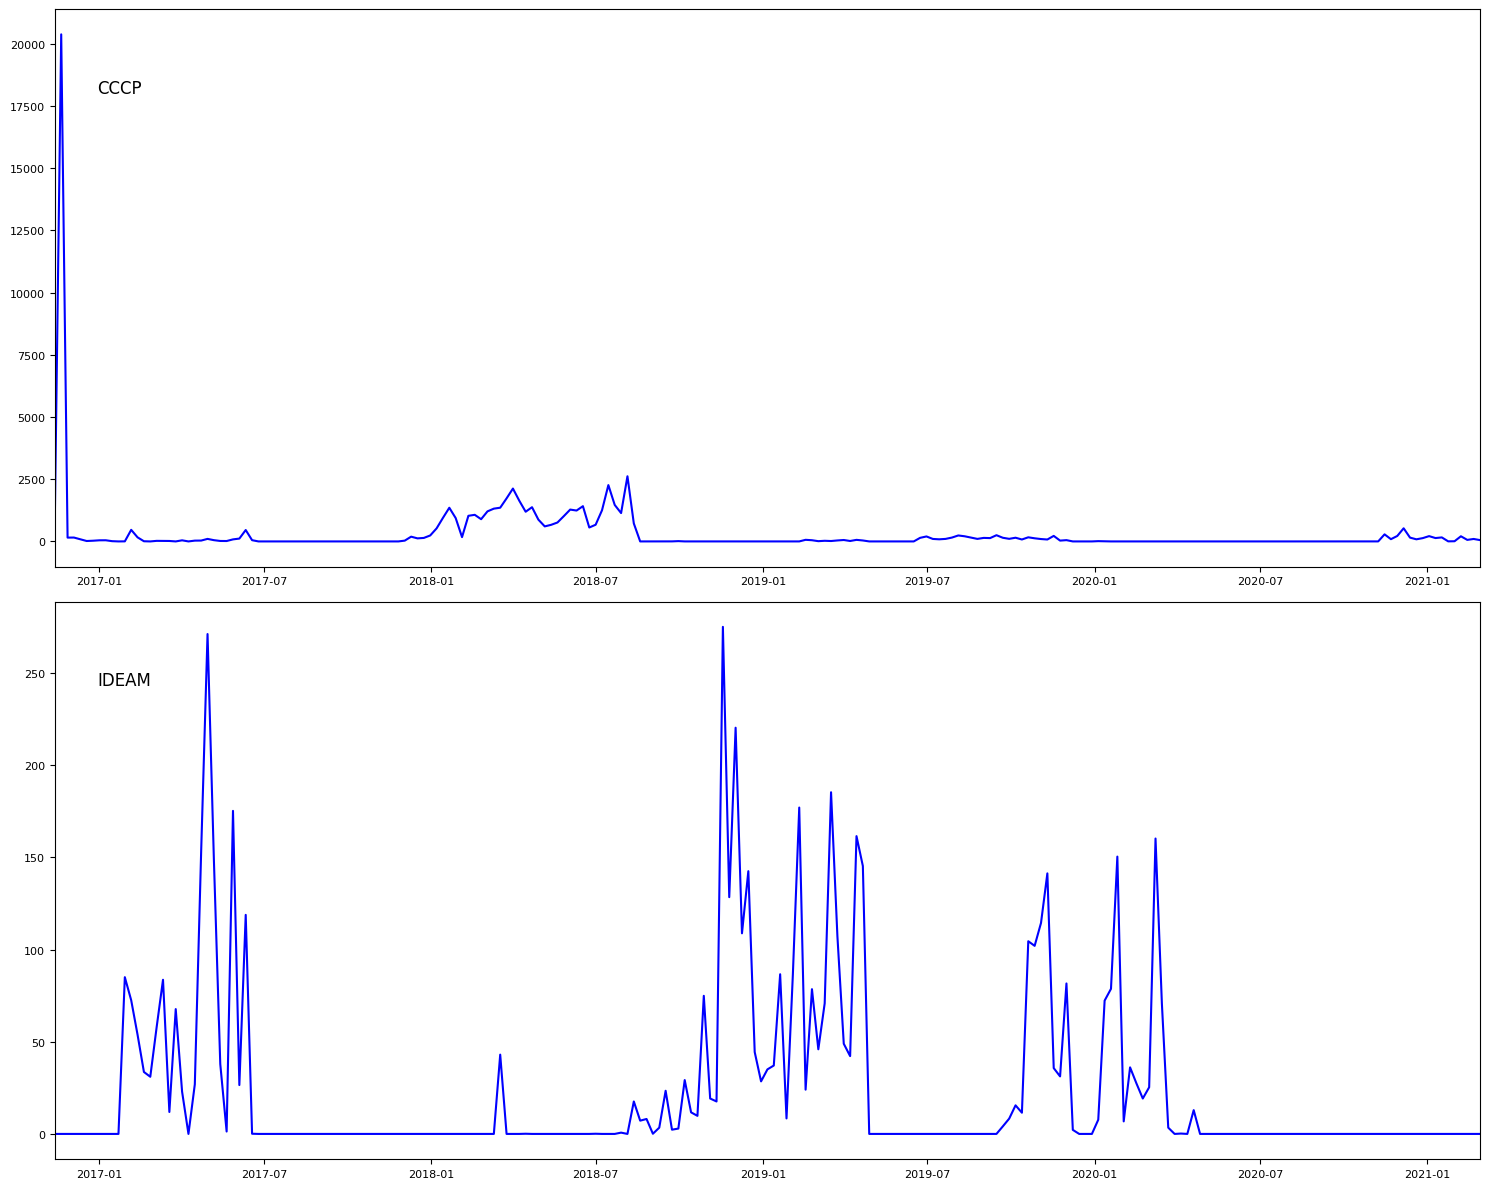

In [18]:


# Crear un dataframe con solo las filas con datos en todas las columnas
estaciones_con_datos = data_stations.dropna()
estaciones_con_datos.shape
# Muestra cuantas celdas con datos nulos o faltantes tiene cada columna de la base de datos

print(estaciones_con_datos.isnull().sum())

estaciones_con_datos = estaciones_con_datos.resample('W').sum()
# Filtrar solo los valores mayores que 0 en el DataFrame
#estaciones_con_datos = estaciones_con_datos[estaciones_con_datos > 0]
#estaciones_con_datos = estaciones_con_datos[estaciones_con_datos < 1500] # filtro que se coloca por unos datos sospechosos que se intentan comparar toman valores demasiado altos


# Gráficar
fig, axs = plt.subplots(nrows=estaciones_con_datos.shape[1], ncols=1, figsize=(15, 12)) # Ajustar el número de "nrows" por el número de columnas a gráficar
for i, col in enumerate(estaciones_con_datos.columns[0:]):
    fila = i
    columna = 0
    ax = axs[fila]
    ax.plot(estaciones_con_datos.index, estaciones_con_datos[col], color='blue')
    ax.set_ylabel('', fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.set_xlim(estaciones_con_datos.index.min(), estaciones_con_datos.index.max())
    ax.text(0.03, 0.85, col, transform=ax.transAxes, fontsize=12)
plt.subplots_adjust(hspace=0.05)
plt.tight_layout()
plt.show()

,CCCP,IDEAM
CCCP,1.000000,-0.196541
IDEAM,-0.196541,1.000000


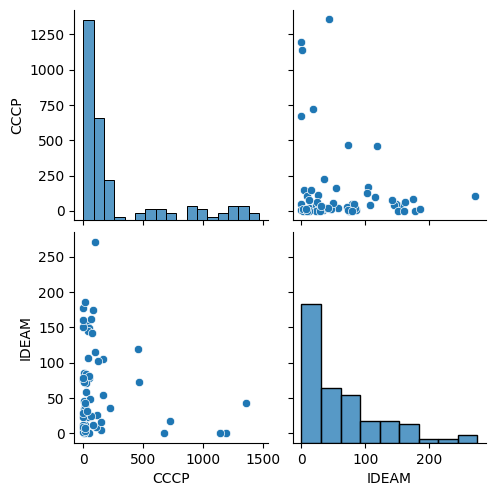

In [8]:
import seaborn as sns 
# Método gráfico de dispersión
sns.pairplot(estaciones_con_datos)
# Metodo numerico
estaciones_con_datos.corr()

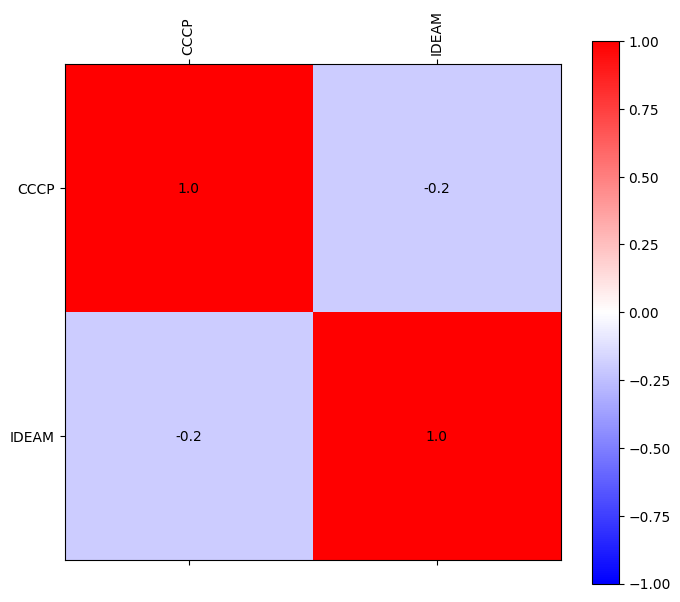

In [9]:
import matplotlib.pyplot as plt

# Calcular la matriz de correlación
matriz = estaciones_con_datos.corr()

# Crear la figura de la matriz de correlación
plt.matshow(matriz, cmap="bwr", vmin=-1, vmax=1)

# Configurar etiquetas de los ejes X e Y
plt.xticks(range(len(matriz.columns)), estaciones_con_datos.columns, rotation=90)
plt.yticks(range(len(matriz.columns)), estaciones_con_datos.columns)

# Agregar los valores de la correlación en cada celda de la matriz
for i in range(len(matriz.columns)):
    for j in range(len(matriz.columns)):
        plt.text(i, j, round(matriz.iloc[i, j], 2), ha="center", va="center", color="black")

# Agregar barra de colores
plt.colorbar()

# Ajustar el tamaño de la figura
plt.gcf().set_size_inches(8, 7)

# Mostrar la matriz de correlación
plt.show()


In [10]:
#Organizamos un dataframe con tres estaciones (2 estaciones para ser predictoras y 1 para ser predecida)
data_stations2 = estaciones_con_datos[["CCCP", "IDEAM"]] #ajuste
data_stations2.head(2)
data_stations2.isnull().sum()

CCCP     100
IDEAM    138
dtype: int64

In [11]:
#Solo se dejan las filas que tengan datos en las tres estaciones
fechas_con_datos = data_stations2.dropna() #ajuste
fechas_con_datos.index.min()

Timestamp('2017-01-29 00:00:00+0000', tz='UTC')

Ecuación de la recta: y =  -0.93 x +  203.25
Coeficiente de correlación:  -0.19654127313461145
Coeficiente de determinación:  0.038628472045373896


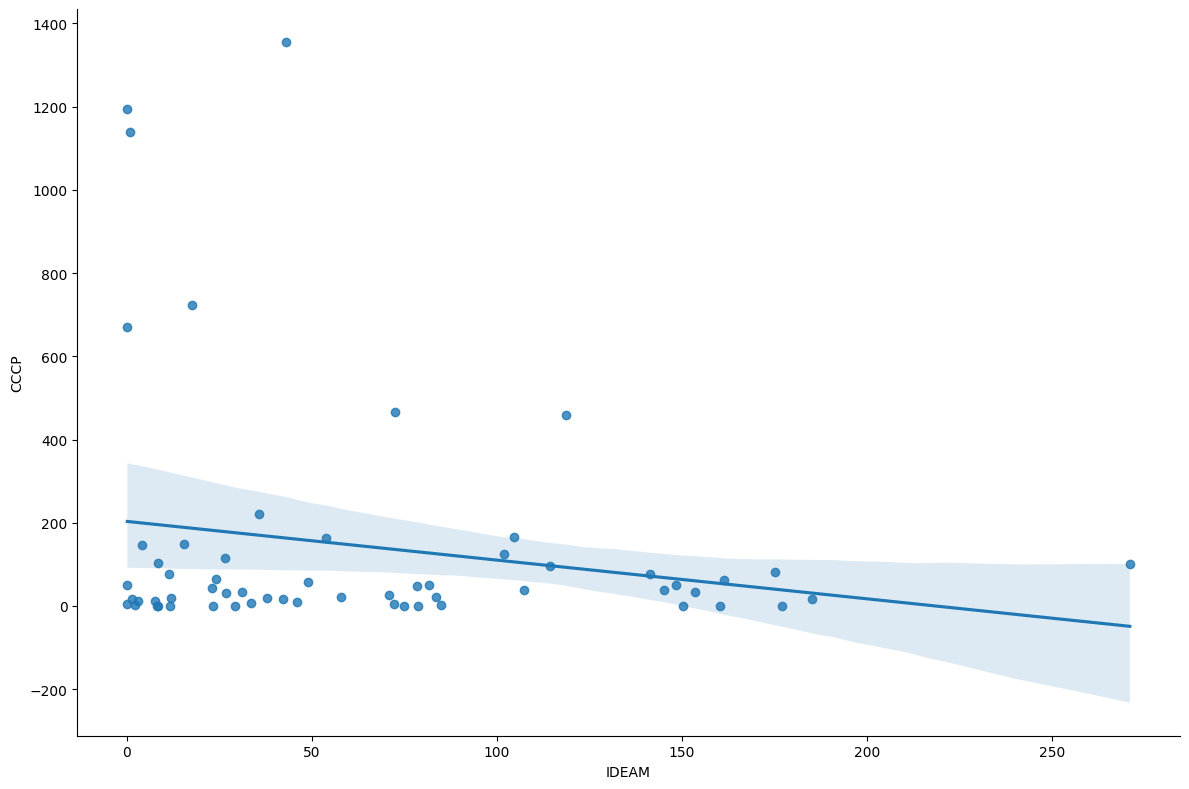

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import numpy as np
#Gráfico de dispersión 2 variables con centralidad
predictora = 'IDEAM'
predecir = 'CCCP'
modelo = LinearRegression()# generamos la regresión lineal
modelo.fit(fechas_con_datos[[predictora]], fechas_con_datos[predecir])# entrenamos el modelo
print ('Ecuación de la recta: y = ', round(modelo.coef_[0],2),'x + ', round(modelo.intercept_,2))#obtenemos la ecuación de la recta
print ('Coeficiente de correlación: ', np.corrcoef(fechas_con_datos[predictora], fechas_con_datos[predecir])[0,1])#obtenemos el coeficiente de correlación
print ('Coeficiente de determinación: ', r2_score(fechas_con_datos[predecir], modelo.predict(fechas_con_datos[[predictora]])))#obtenemos el coeficiente de determinación
sns.lmplot(x=predictora, y=predecir, data =fechas_con_datos, height=8, aspect=1.5) # Gráfico según variables
plt.show() #Mostrar 

d:\master BigData\01 proyecto final\codigos\venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(


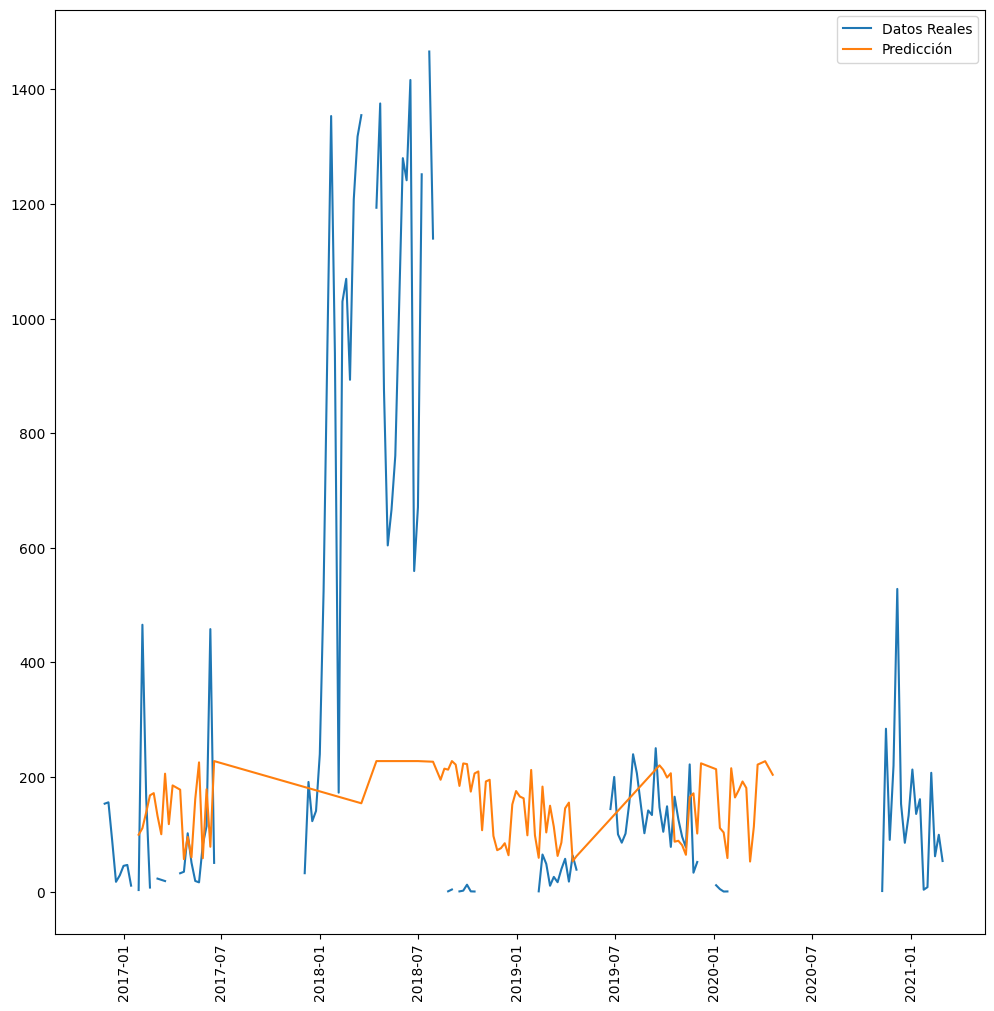

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor

# Datos y variables
# Utiliza solo una variable predictora
xTrain = fechas_con_datos[[predictora]]  # Variable predictora (dataframe con una sola columna)
yTrain = fechas_con_datos[[predecir]].values.flatten()  # Variable a predecir (lista)

# Escalador para estandarizar los datos
scaler = StandardScaler().fit(xTrain.values)
xTrainScaled = scaler.transform(xTrain.values)

# Generar el modelo de regresión de red neuronal
regr = MLPRegressor(random_state=1, max_iter=5000).fit(xTrainScaled, yTrain)

# Datos de prueba
xTest = data_stations2[[predictora]].dropna()  # Utiliza solo la misma variable predictora
xTestScaled = scaler.transform(xTest.values)

# Realizar la predicción
yPredict = regr.predict(xTestScaled)

# Gráfico comparativo de resultados
fig, ax = plt.subplots(figsize=(12, 12), sharex=True, sharey=True)
ax.plot(data_stations2.index, data_stations2[predecir], label='Datos Reales')  # Ajuste real
ax.plot(xTest.index, yPredict, label='Predicción')  # Predicción del modelo
plt.legend()
plt.xticks(rotation='vertical')
plt.show()


In [14]:
import numpy as np

# Crear una nueva columna para completar los datos
data_stations2[predecir + '_complet'] = np.nan  # Inicializar con NaN

# Iterar por las filas para completar los valores faltantes
for index, row in data_stations2.iterrows():
    if np.isnan(row[predecir]) and ~np.isnan(row[predictora]):  # Comprobar NaN solo en `predictora`
        # Escalar el valor de la predictora
        rowScaled = scaler.transform([[row[predictora]]])
        # Predecir y asignar el valor
        data_stations2.loc[index, predecir + '_complet'] = regr.predict(rowScaled)[0]
    elif not np.isnan(row[predecir]):  # Si el valor original existe, copiarlo directamente
        data_stations2.loc[index, predecir + '_complet'] = row[predecir]



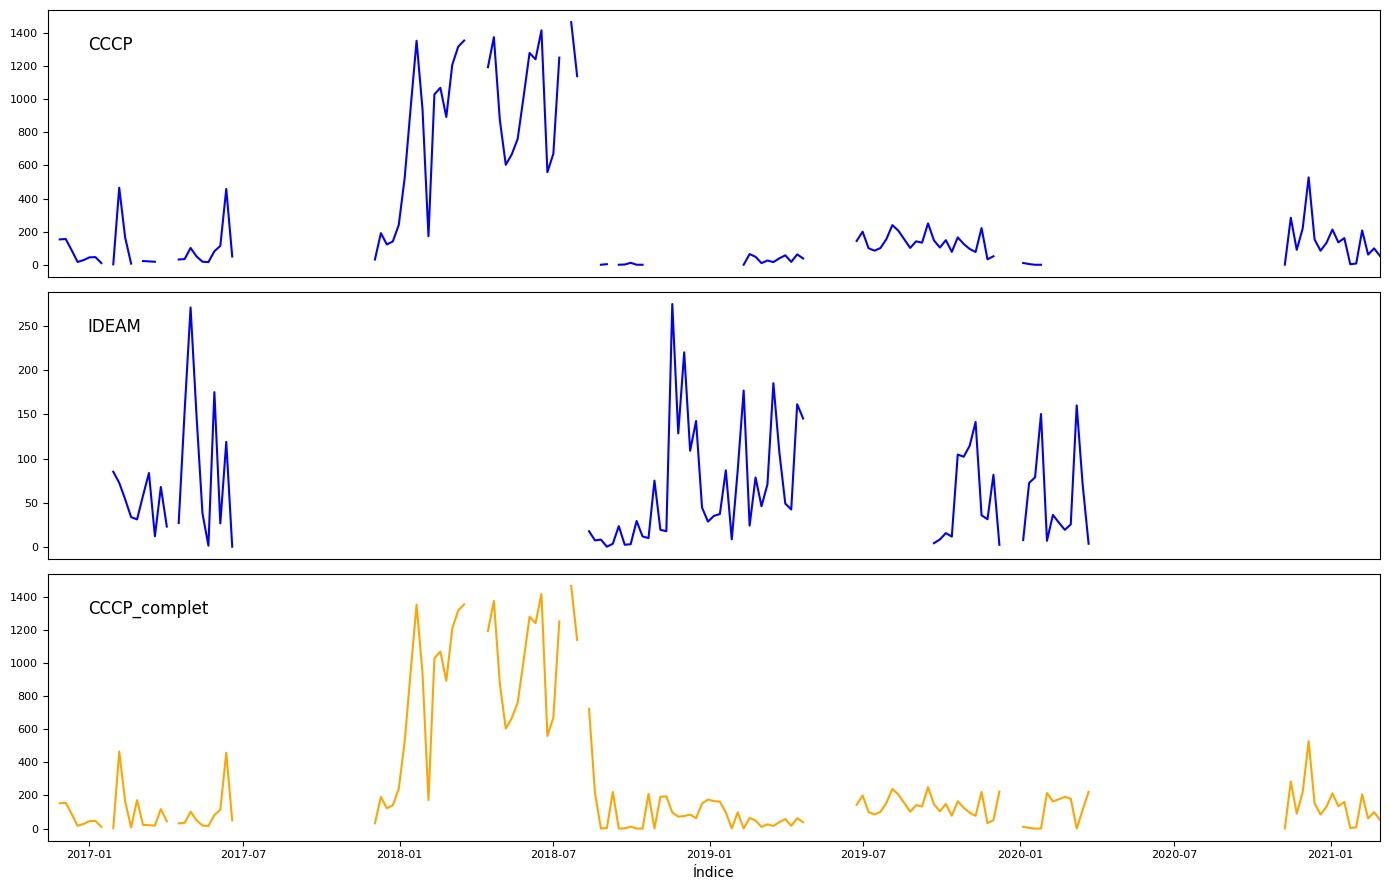

In [15]:
fig, axs = plt.subplots(nrows=len(data_stations2.columns), ncols=1, figsize=(14, 9))
colores = ['blue', 'blue', 'orange', 'red']  # Colores para las líneas

# Iterar sobre las columnas del DataFrame
for i, col in enumerate(data_stations2.columns):  # Enumerar las columnas del DataFrame
    ax = axs[i]  # Seleccionar el subgráfico correspondiente
    ax.plot(data_stations2.index, data_stations2[col], color=colores[i % len(colores)])  # Graficar la columna
    ax.set_ylabel('', fontsize=10)  # Etiqueta del eje Y (puedes personalizar)
    ax.tick_params(axis='both', which='major', labelsize=8)  # Ajustar el tamaño de las etiquetas
    ax.set_xlim(data_stations2.index.min(), data_stations2.index.max())  # Limitar el eje X a los valores disponibles
    ax.text(0.03, 0.85, col, transform=ax.transAxes, fontsize=12)  # Añadir el nombre de la columna en cada subgráfico

    # Ocultar etiquetas del eje X para los gráficos excepto el último
    if i != len(data_stations2.columns) - 1:
        ax.set_xticks([])
    else:
        ax.set_xlabel('Índice', fontsize=10)  # Etiqueta del eje X en el último gráfico

# Ajustar espacio entre gráficos
plt.subplots_adjust(hspace=0.1)
plt.tight_layout()
plt.show()


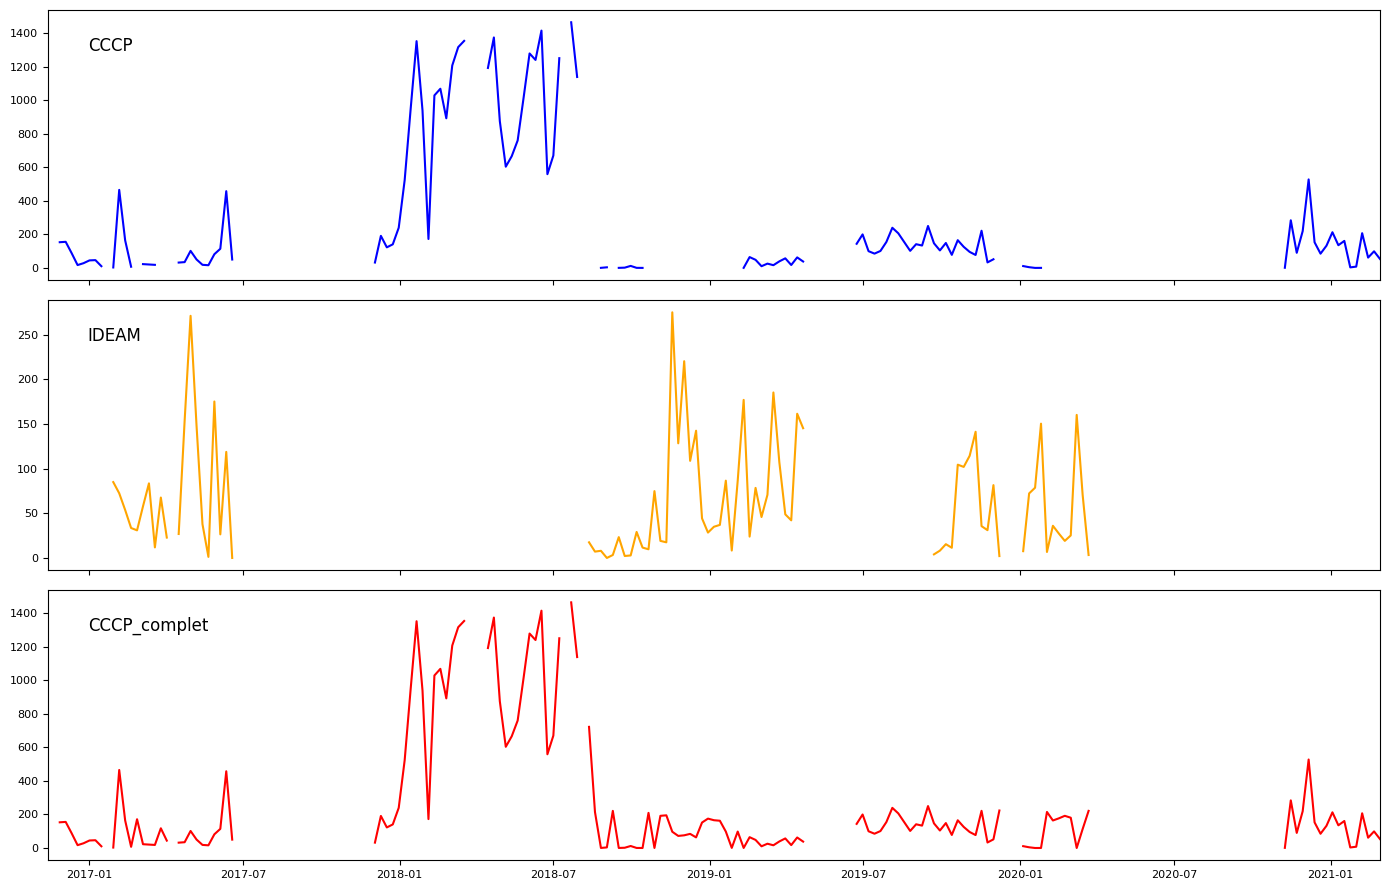

In [16]:
import matplotlib.pyplot as plt

# Crear subgráficos dinámicos según el número de columnas
fig, axs = plt.subplots(nrows=len(data_stations2.columns), ncols=1, figsize=(14, 9), sharex=True)

# Lista de colores para las líneas
colores = ['blue', 'orange', 'red', 'green']

# Manejo de subgráficos si solo hay una columna
if len(data_stations2.columns) == 1:
    axs = [axs]

# Iterar sobre las columnas del DataFrame
for i, col in enumerate(data_stations2.columns):
    ax = axs[i]  # Seleccionar el subgráfico correspondiente
    ax.plot(data_stations2.index, data_stations2[col], color=colores[i % len(colores)], label=col)
    ax.set_ylabel('', fontsize=10)  # Etiqueta del eje Y (puedes personalizar)
    ax.tick_params(axis='both', which='major', labelsize=8)  # Ajustar el tamaño de las etiquetas
    ax.set_xlim(data_stations2.index.min(), data_stations2.index.max())  # Limitar el eje X a los valores disponibles
    ax.text(0.03, 0.85, col, transform=ax.transAxes, fontsize=12)  # Añadir el nombre de la columna en cada subgráfico


# Ajustar espacio entre gráficos
plt.subplots_adjust(hspace=0.3)  # Incremento del espacio entre gráficos para mayor claridad
plt.tight_layout()
plt.show()


In [17]:
from graphics_utils.go import multi_line
fig = multi_line(data_stations2['CCCP'], data_stations2['IDEAM'])
fig.show()

TypeError: multi_line() takes 0 positional arguments but 2 were given